In [1]:
import json
import csv
from pprint import pprint
import re
import os
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import pandas as pd
wordnet_lemmatizer = WordNetLemmatizer()

# Useful Functions

In [2]:
def checkExist(dict, memberId):
    if(memberId in dict):
        return True
    return False

def dataLoad(filename):
    with open(filename) as data_file:
        data = json.load(data_file)
    return data

def transformWord(word):
    word = re.sub(r"[^\x00-\x7f]+", "", word)
    word = re.sub(r"^-", "", word)
    word = re.sub(r"^'", "", word)
    word = re.sub(r"-$", "", word)
    word = re.sub(r"'$", "", word)
    return word

def removeSpecialChars(word):
    specialChars = ['_', ',', ';', '"', ".", "=", "!", "?", "*"]
    for char in specialChars:
        word = word.replace(char, ' ')
    return word

In [3]:
def statistics(data, table):
    for item in data:
        averageScore = 0
        totalScore = 0
        nbScore = 0
        for listenScore in item['listenScore']:
            if(listenScore['score'] != -1):
                totalScore += listenScore['score']
                nbScore += 1
        if nbScore != 0:
            averageScore = totalScore / nbScore
        wordList = []
        for vocabulary in item['vocabularyList']:
            if(int(vocabulary['postId']) == 3913):
                continue
            wordSplit = removeSpecialChars(vocabulary['word'].lower().strip()).split()
            for split in wordSplit:
                cleanedSplit = transformWord(split.strip())
                if(re.match("^[0-9]+$", cleanedSplit)):
                    continue
                if(cleanedSplit not in wordList):
                    wordList.append(cleanedSplit)
        if(checkExist(members, item['memberId']) == False):
            memberId = item['memberId'].encode('utf-8')
            members[memberId] = memberId
            table.append([item['memberId'], len(item['chosenVideo']), len(wordList), averageScore, ';'.join(wordList).encode('utf-8') ])


In [4]:
videoList = []
studentTable = []
members = {}
data = dataLoad('dataset/studentBehaviorInfo_1.json')
statistics(data, studentTable)

data = dataLoad('dataset/studentBehaviorInfo_2.json')
statistics(data, studentTable)

data = dataLoad('dataset/studentBehaviorInfoOver40Class_1213.json')
statistics(data, studentTable)

with open('processed/StudentBehaviorFile.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting = csv.QUOTE_MINIMAL)
    csvwriter.writerow(["memberId", "numberVideosChosen", "numberOfWordsSaved", "averageScore", "wordList"])
    cpt = 0
    for item in studentTable:
        cpt += 1
        csvwriter.writerow(["'" + str(item[0]) + "'", item[1], item[2], item[3], item[4]])

print("Number of rows: {0} ".format(cpt))

Number of rows: 7098 


In [5]:
df_behavior = pd.read_csv("processed/StudentBehaviorFile.csv")

In [6]:
df_behavior.columns

Index(['memberId', 'numberVideosChosen', 'numberOfWordsSaved', 'averageScore',
       'wordList'],
      dtype='object')

In [7]:
df_behavior_aggregated = df_behavior.groupby('memberId').sum()

In [8]:
# Total number of users
df_behavior_aggregated.count()

numberVideosChosen    6353
numberOfWordsSaved    6353
averageScore          6353
dtype: int64

In [9]:
# Average number of watched videos
df_behavior_aggregated['numberVideosChosen'].mean()

12.125137730206202

In [10]:
# Average number of users' saved words
df_behavior_aggregated['numberOfWordsSaved'].mean()

337.58381866834566

In [11]:
# Users' average score
df_behavior_aggregated['averageScore'].mean()

73.22664154602094

In [12]:
words = df_behavior['wordList'].unique()

In [13]:
words = ';'.join(words).split(';')

In [14]:
uniquewords = set(words)

In [15]:
len(uniquewords)

18284

In [16]:
word_domains = {'word': [], 'domain': []}
for word in uniquewords:
    l_word = wordnet_lemmatizer.lemmatize(word)
    synets = wn.synsets(l_word)
    if not synets:
        continue
    
    for synet in synets:
        domains = synet.topic_domains()
        if not domains:
            continue
        for domain in domains:
            word_domains['word'].append(word)
            word_domains['domain'].append(domain.name().split('.')[0])

In [17]:
df_word_domains = pd.DataFrame(data=word_domains)

In [18]:
df_word_domains.head()

,domain,word
0,performing_arts,costume
1,law,instrument
2,music,instrument
3,music,trumpet
4,river,bend


In [19]:
df_final = df_word_domains.groupby('domain').count()

In [20]:
hist = df_final.sort_values(['word'], ascending=False).head(25)

In [21]:
hist

,word
domain,
law,221
music,171
military,162
cooking,147
baseball,131
sport,129
computer_science,128
chemistry,125
medicine,110


In [22]:
hist.index

Index(['law', 'music', 'military', 'cooking', 'baseball', 'sport',
       'computer_science', 'chemistry', 'medicine', 'commerce', 'art',
       'physics', 'mathematics', 'performing_arts', 'biology', 'linguistics',
       'golf', 'farming', 'card_game', 'photography', 'chess', 'driving',
       'statistics', 'crime', 'astronomy'],
      dtype='object', name='domain')

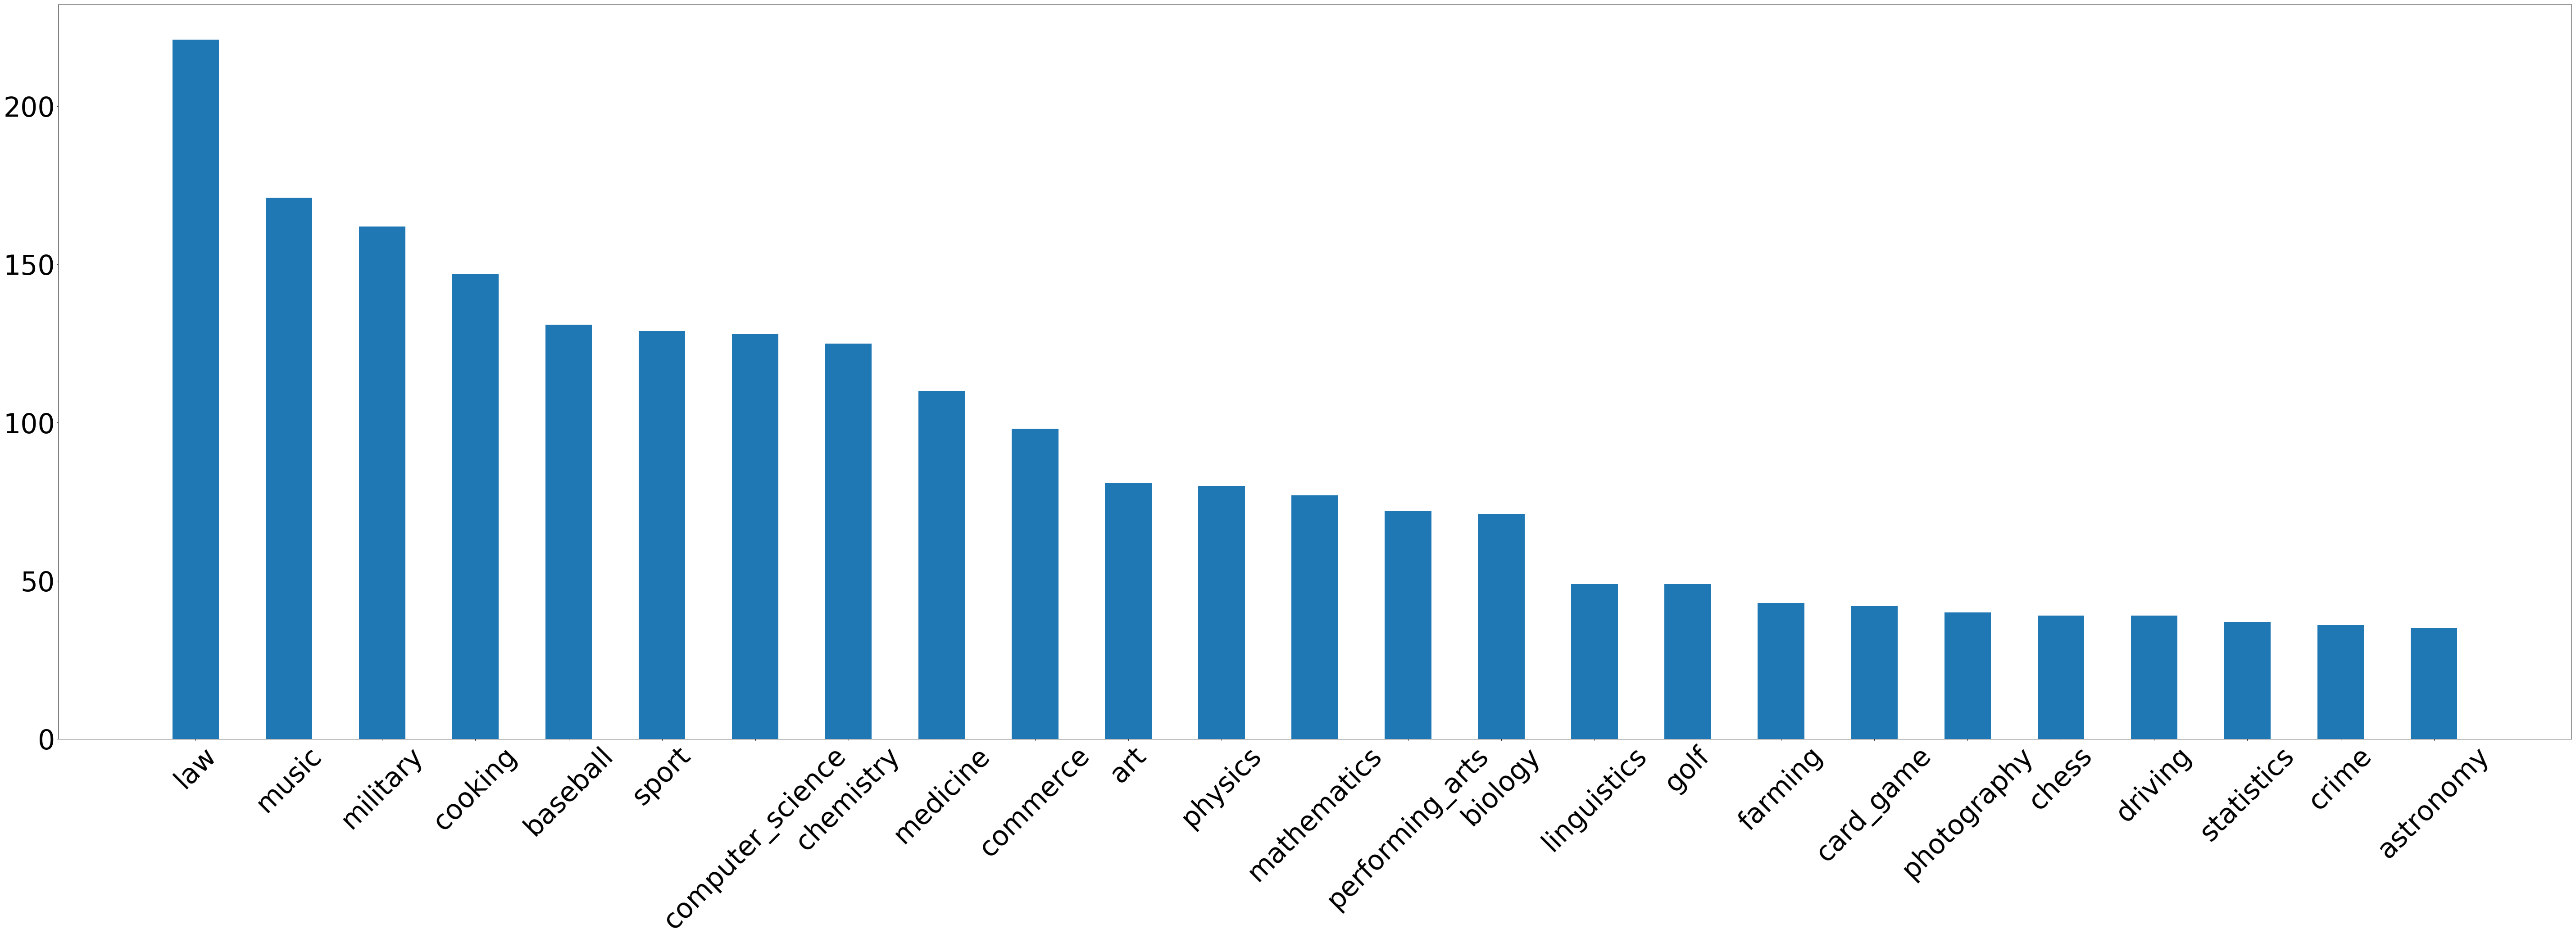

In [23]:
import matplotlib.pyplot as plt
import numpy as np

labels = hist.index
f = plt.figure(figsize=(100,30))
ax = f.add_subplot(111)

width=0.5
bins = [i-width/2 for i in range(1, 26)]
ax.bar(left=bins,height=hist['word'], data=hist['word'],width=width)
ax.set_xticks([i-width/2 for i in range(1, len(hist.index)+1)])
ax.set_xticklabels(hist.index,rotation=45, fontsize=60)
ax.set_yticklabels([0, 50, 100, 150, 200, 250, 300],fontsize=60)
plt.show()